In [79]:
import pandas as pd
import numpy as np
import csv
import json
import re
import torch
from itertools import chain

import seaborn as sns
import matplotlib.pyplot as plt

from allennlp_models.common.ontonotes import Ontonotes

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# progress bar
from tqdm import tqdm

In [2]:
# setup device based on availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device: {}".format(device))

Using device: cpu


In [9]:
class LoadData():
    def __init__(self, path):
        self.path = path
        self.all_sentences = []
        self.all_sentences_pos = []
    
    def get_data(self):
        onto = Ontonotes()
        ds = onto.dataset_iterator(self.path)
        for x in ds:
            sentences = x.words
            pos_tags = x.pos_tags
            self.all_sentences.append(sentences)
            self.all_sentences_pos.append(pos_tags)
        return self.all_sentences, self.all_sentences_pos

In [10]:
# load the train data
train_data_path = '../code_base/ontonotes_data/train/data/english/annotations'
train_data = LoadData(train_data_path)
# retrieve the sentences from the train data & their corresponding
# POS tags
train_sent, train_sent_pos = train_data.get_data()

In [11]:
# load the validation data
dev_data_path = '../code_base/ontonotes_data/development/data/english/annotations'
val_data = LoadData(dev_data_path)
# retrieve the sentences from the train data & their corresponding
# POS tags
val_sent, val_sent_pos = val_data.get_data()

In [12]:
print("Number of sentences in train data: ", len(train_sent))

Number of sentences in train data:  115812


In [13]:
print("Number of sentences in validation data: ", len(val_sent))

Number of sentences in validation data:  15680


Validation data

In [48]:
class PrepareDataForAugmentation():
    def __init__(self, data, data_pos_tags):
        self.data = data
        self.pos_tags = data_pos_tags
        self.gendered_sentences = []
        self.gendered_sentences_pos = []
        self.word_mapping_male_2_female = {}
        self.word_mapping_female_2_male = {}
        self.swapped_sentences = []
        self.original_sentences = []
        self.masked_orig_sentences = []
        self.masked_swapped_sentences = []
        
    def extract_gendered_sentences(self):
        pronoun_list = ["he" "him", "his", "her", "she"]
        for idx, sentence in enumerate(self.data):
            for word in sentence:
                if word in pronoun_list:
                    # gendered pronoun present
                    self.gendered_sentences.append((idx, sentence))
                    break
    
    def extract_gendered_sent_pos_tags(self):
        for idx, sent in self.gendered_sentences:
            self.gendered_sentences_pos.append(self.pos_tags[idx])
            
    def create_word_male_female_mappings(self):
        # load male to female mapping for gender-specific words
        word_data = None
        with open('../code_base/cda_default_pairs.json', 'r') as f:
            word_data = json.load(f)
        
        # convert to a dict for easier mapping
        for mapping in word_data:
            self.word_mapping_male_2_female[mapping[0]] = mapping[1]
        self.word_mapping_female_2_male = \
            {value: key for key, value in self.word_mapping_male_2_female.items()}
        
        
    def swap_gendered_words(self, sentence, pos_tags):
        flipped_sentence = []
        original_sentence = []
        for idx, word in enumerate(sentence):
            pos_tag = pos_tags[idx]
            if word == "him":
                flipped_sentence.append("her")
                original_sentence.append(word)
            elif word == "his" and pos_tag == "NNS":
                flipped_sentence.append("hers")
                original_sentence.append(word)
            elif word == "his" and (pos_tag == "PRP" or pos_tag == "PRP$"):
                flipped_sentence.append("her")
                original_sentence.append(word)
            elif word == "her" and pos_tag == "PRP$":
                flipped_sentence.append("his")
                original_sentence.append(word)
            elif word == "her" and pos_tag == "PRP":
                flipped_sentence.append("him")
                original_sentence.append(word)
            elif word == "hers":
                flipped_sentence.append("his")
                original_sentence.append(word)
            elif word in self.word_mapping_male_2_female.keys():
                flipped_sentence.append(self.word_mapping_male_2_female[word])
                original_sentence.append(word)
            elif word in self.word_mapping_female_2_male.keys():
                flipped_sentence.append(self.word_mapping_female_2_male[word])
                original_sentence.append(word)
            elif pos_tag == "NNP":
                # replace with a mask
                flipped_sentence.append("[NAME]")
                original_sentence.append("[NAME]")
            else:
                flipped_sentence.append(word)
                original_sentence.append(word)

        return original_sentence, flipped_sentence
    
    def lower_case_sentences(self, sentence):
        sentence = [word.lower() for word in sentence]
        return sentence

    def swap_sentences(self):
        print("In swap sentences...")
        swapped_sentences = []
        original_sentences = []
        for idx, sentence in enumerate(self.gendered_sentences):
            sentence = self.lower_case_sentences(sentence[1])
            original_sent, swapped_sent = \
                self.swap_gendered_words(sentence, self.gendered_sentences_pos[idx])
            swapped_sentences.append(swapped_sent)
            original_sentences.append(original_sent)
            
        return original_sentences, swapped_sentences
    
    def generate_swapped_sentences(self):
        self.extract_gendered_sentences()
        self.extract_gendered_sent_pos_tags()
        self.create_word_male_female_mappings()
        self.original_sentences, self.swapped_sentences = \
            self.swap_sentences()
        return self.original_sentences, self.swapped_sentences
    
    def combine_gendered_swapped_sentences(self):
        combined_original_sentences = []
        combined_swapped_sentences = []
        for sent in self.original_sentences:
            combined_original_sentences.append(' '.join(sent))
        for sent in self.swapped_sentences:
            combined_swapped_sentences.append(' '.join(sent))
        return combined_original_sentences, combined_swapped_sentences
    
    # Used to mask the gender pronouns, so that we can predict these
    # using our model
    def replace_pronouns(self, data):
        masked_sentences = []
        for sent in data:
            sent = sent.lower()
            pronoun_regex = r"\bhis\b|\bher\b|\bhim\b|\bshe\b|\bhe\b|\bhers\b"
            matched_strings = re.findall(pronoun_regex, sent)
            for gender_pronoun in matched_strings:
                pronoun = gender_pronoun
                masked_sent = re.sub(pronoun_regex, "[MASK]", sent)
                masked_sentences.append([masked_sent, pronoun])
        return masked_sentences
    
    def mask_gender_pronouns(self):
        orig_sentences, swapped_sentences = \
            self.combine_gendered_swapped_sentences()
        self.masked_original_sentences = self.replace_pronouns(orig_sentences)
        self.masked_swapped_sentences = self.replace_pronouns(swapped_sentences)

In [49]:
train_processed_data = PrepareDataForAugmentation(train_sent, train_sent_pos)
train_swapped_sentences = train_processed_data.generate_swapped_sentences()

In swap sentences...


In [50]:
print(train_processed_data.original_sentences[10])

['[NAME]', 'tells', 'his', 'students', 'that', 'if', 'they', 'put', 'other', 'things', 'aside', 'and', 'concentrate', 'on', 'their', 'studies', 'for', 'three', 'weeks', ',', 'maybe', 'they', "'ll", 'find', 'the', 'answer', 'themselves', '.']


In [54]:
val_processed_data = PrepareDataForAugmentation(val_sent, val_sent_pos)
val_swapped_sentences = val_processed_data.generate_swapped_sentences()

In swap sentences...


In [55]:
train_processed_data.mask_gender_pronouns()
val_processed_data.mask_gender_pronouns()

In [58]:
train_processed_data.masked_swapped_sentences[0]

['[name] relates that as a youth [MASK] studied because [MASK] was forced to , but now [MASK] motivations for learning are far greater - so great in fact that [MASK] registered for three classes at the start of the semester , a decision [MASK] has come to regret for lack of time .',
 'she']

In [59]:
val_processed_data.masked_original_sentences[0]

['on [name] 25 [name] [name] [name] - [name] wrapped up [MASK] first overseas trip since taking office , swinging through three countries in [name] [name] and another three in [name] .',
 'his']

In [65]:
len(train_processed_data.masked_swapped_sentences), len(train_processed_data.masked_original_sentences)

(13915, 13915)

Exploratory Data Analysis

In [63]:
# store the data into pandas dataframe
train_original_data = pd.DataFrame(train_processed_data.masked_original_sentences, columns=['text', 'pronouns'])
train_flipped_data = pd.DataFrame(train_processed_data.masked_swapped_sentences, columns=['text', 'pronouns'])
val_original_data = pd.DataFrame(val_processed_data.masked_original_sentences, columns=['text', 'pronouns'])
val_flipped_data = pd.DataFrame(val_processed_data.masked_swapped_sentences, columns=['text', 'pronouns'])

In [66]:
# Exploratory data analysis
train_original_data.describe()

,text,pronouns
count,13915,13915
unique,8241,6
top,"when [MASK] reached the river xanthus , which ...",his
freq,14,6219


In [68]:
len(train_original_data) == len(train_flipped_data)

True

In [69]:
train_original_data.shape, train_flipped_data.shape

((13915, 3), (13915, 2))

In [70]:
train_original_data.pronouns.value_counts()

his     6219
he      2538
she     2310
her     2188
him      654
hers       6
Name: pronouns, dtype: int64

In [71]:
train_flipped_data.pronouns.value_counts()

her    6672
she    2538
he     2310
his    1678
him     717
Name: pronouns, dtype: int64

In [73]:
# drop duplicate rows
train_original_data = train_original_data.drop_duplicates(keep='first')
train_flipped_data = train_flipped_data.drop_duplicates(keep='first')
val_original_data = val_original_data.drop_duplicates(keep='first')
val_flipped_data = val_flipped_data.drop_duplicates(keep='first')

In [75]:
train_original_data.shape, train_flipped_data.shape

((11575, 3), (11226, 2))

In [77]:
train_original_data['length'] = train_original_data['text'].map(lambda text: len(text))
train_original_data.head()

,text,pronouns,length
0,[name] relates that as a youth [MASK] studied ...,he,279
2,[name] relates that as a youth [MASK] studied ...,his,279
5,ever since graduating with a degree in mechani...,his,224
6,"[name] [name] - [name] , a researcher at the [...",his,247
7,[MASK] divides [MASK] schedule into three - mo...,she,221


The average length of a sentence is: 133.82704103671705


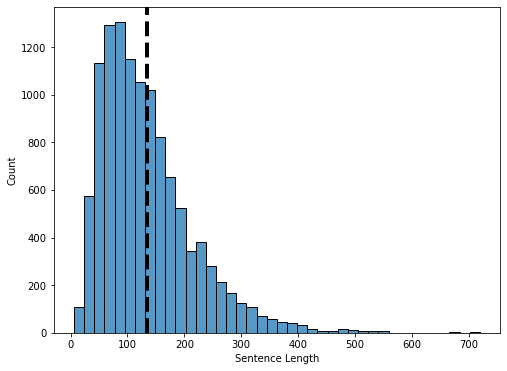

In [85]:
text_length = train_original_data.length.values
mean_length = np.mean(text_length)
print ("The average length of a sentence is: %s" % (mean_length))

fig = plt.figure(figsize=(8,6))
ax = fig.gca()
# Look at the distribution of the data
ax = sns.histplot(x=text_length, bins=40, ax=ax, kde=False)
ax.axvline(mean_length, lw=4, ls='dashed', color='black')
ax.set(xlabel='Sentence Length')
plt.show()

Total pronoun counts =  5343


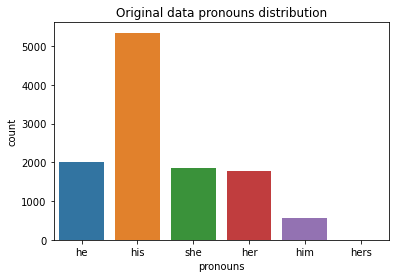

In [83]:
train_original_data['pronouns'].value_counts()
print("Total pronoun counts = ", train_original_data['pronouns'].value_counts()[0])
ax = sns.countplot(x=train_original_data['pronouns']).set(title='Original data pronouns distribution')

Total pronoun counts =  5281


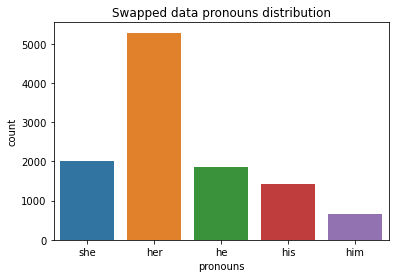

In [84]:
train_flipped_data['pronouns'].value_counts()
print("Total pronoun counts = ", train_flipped_data['pronouns'].value_counts()[0])
ax = sns.countplot(x=train_flipped_data['pronouns']).set(title='Swapped data pronouns distribution')

In [96]:
def load_winogender_data(path):
    winogender_data = []
    with open(path) as f:
        for line in f:
            winogender_data.append(line.rstrip())
    return winogender_data

def load_occupation_stats(path):
    occupation_stats = pd.read_csv(path, sep='\t')
    return occupation_stats

In [100]:
test_data_path = '../code_base/processed_wino_data.txt'
winogender_data_list = load_winogender_data(test_data_path)
occupation_stats_path = '../code_base/winogender_data/occupations-stats.tsv'
occupation_stats_df = load_occupation_stats(occupation_stats_path)
winogender_data = pd.DataFrame(winogender_data_list, columns=['sentence'])
winogender_data = winogender_data.merge(occupation_stats_df[['occupation', 'bls_pct_female']],
                                        how='outer', left_index=True, 
                                        right_index=True)

In [101]:
winogender_data.head()

,sentence,occupation,bls_pct_female
0,The [technician] told the customer that [he] h...,technician,40.34
1,The taxpayer met with the [accountant] to find...,accountant,59.70
2,The employee gave the [supervisor] feedback on...,supervisor,38.64
3,The [engineer] informed the client that [he] w...,engineer,10.72
4,The [worker] told the pedestrian that [he] was...,worker,37.92


In [105]:
len(winogender_data['occupation'])

60

In [109]:
winogender_data[winogender_data['bls_pct_female'] >50.00]['occupation'].value_counts()

accountant       1
instructor       1
broker           1
dietitian        1
auditor          1
cashier          1
dispatcher       1
hygienist        1
paralegal        1
baker            1
hairdresser      1
nutritionist     1
appraiser        1
examiner         1
veterinarian     1
practitioner     1
educator         1
planner          1
teacher          1
pathologist      1
bartender        1
nurse            1
psychologist     1
pharmacist       1
librarian        1
receptionist     1
administrator    1
therapist        1
counselor        1
clerk            1
secretary        1
Name: occupation, dtype: int64

In [110]:
def create_augmented_data(original_data, flipped_data):
    common_indexes = flipped_data.index.intersection(original_data.index)
    original_data = original_data.loc[common_indexes]
    flipped_data = flipped_data.loc[common_indexes]
    augmented_data = pd.concat([original_data, flipped_data])
    return augmented_data

In [138]:
augmented_train_data = create_augmented_data(train_original_data, train_flipped_data)
augmented_val_data = create_augmented_data(val_original_data, val_flipped_data)

In [114]:
augmented_train_data.head(8)

,text,pronouns,length
0,[name] relates that as a youth [MASK] studied ...,he,279.0
2,[name] relates that as a youth [MASK] studied ...,his,279.0
5,ever since graduating with a degree in mechani...,his,224.0
6,"[name] [name] - [name] , a researcher at the [...",his,247.0
7,[MASK] divides [MASK] schedule into three - mo...,she,221.0
8,[MASK] divides [MASK] schedule into three - mo...,her,221.0
12,"still , sometimes nothing can be done , such a...",she,202.0
13,"still , sometimes nothing can be done , such a...",her,202.0


In [117]:
len(augmented_train_data), len(augmented_val_data)

(22218, 2726)

In [118]:
augmented_train_data['pronouns'].unique()

array(['he', 'his', 'she', 'her', 'him', 'hers'], dtype=object)

In [128]:
augmented_train_data['pronouns'].value_counts()

her     7064
his     6536
he      3865
she     3865
him      885
hers       3
Name: pronouns, dtype: int64

## Model & Training

Create the model for training

Source inspired from http://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [129]:
# tokenize the data with bert
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [139]:
def find_max_length_seq(data):
    max_seq_len = 0
    for sent in data:
        encoded_ids = tokenizer.encode(sent, add_special_tokens=True)
        max_seq_len = max(max_seq_len, len(encoded_ids))
    return max_seq_len

train_max_seq_len = find_max_length_seq(augmented_train_data['text'])
val_max_seq_len = find_max_length_seq(augmented_val_data['text'])

In [140]:
# pad 10 extra
train_max_seq_len = train_max_seq_len + 10
print("Maximum train sequence length: ", train_max_seq_len)
val_max_seq_len = val_max_seq_len + 10
print("Maximum validation sequence length: ", val_max_seq_len)

Maximum train sequence length:  186
Maximum validation sequence length:  143


In [275]:
def encode_labels(dataset):
    print(len(dataset))
    X = dataset.text.values
    y = dataset.pronouns.values
    mask_id = tokenizer.convert_tokens_to_ids('[MASK]')
    encoded_labels = []
    for sentence, label in zip(X, y):
        sentence_ids = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence))
        label_id = tokenizer.convert_tokens_to_ids(label)
        encoded_label = []
        for ids in sentence_ids:
            if ids == mask_id:
                encoded_label.append(label_id)
            else:
                encoded_label.append(-100)
        encoded_labels.append(encoded_label)
    return encoded_labels

In [276]:
train_encoded_labels = encode_labels(augmented_train_data)
val_encoded_labels = encode_labels(augmented_val_data)

22218
2726


In [209]:
len(val_encoded_labels)

2726

In [277]:
# tokenize the data
# add start & stop tokens [SEP] & [CLS]
# pad the sentences
def encode_data(sentences, masked_labels, max_seq_len):
    encoded_vector = []
    encoded_label = []
    # add_special_tokens = add start and end tokens to every sentence
    # pad_to_max_length = pad the sentence to max sequence length of data
    # return the tokenized IDs as a tensor
    for sent, label in zip(sentences, masked_labels):
        # encode the sentences
        encoded_dict = tokenizer.encode_plus(sent, add_special_tokens=True,
                                             max_length=max_seq_len, truncation=True,
                                             padding='max_length',
                                             return_attention_mask=True, 
                                             return_tensors='pt')
        
        # encode the labels
        encoded_label_dict = tokenizer.encode_plus(label, max_length=max_seq_len, 
                                                   padding='max_length',
                                                   return_tensors='pt')
        
        encoded_vector.append(encoded_dict['input_ids'])
        encoded_label.append(encoded_label_dict['input_ids'])
    return encoded_vector, encoded_label

# get the encoded data
train_encoded_vector, train_encoded_labels = encode_data(augmented_train_data.text.values, 
                                                         train_encoded_labels, train_max_seq_len)
val_encoded_vector, val_encoded_labels = encode_data(augmented_val_data.text.values, val_encoded_labels, 
                                                     val_max_seq_len)

In [214]:
val_encoded_labels[0]

tensor([[ 101, -200, -200, -200, -200, -200, -200, -200, -200, -200, -200, -200,
         -200, -200, -200, -200, -200, -200, -200, -200, -200, 2010, -200, -200,
         -200, -200, -200, -200, -200, -200, -200, -200, -200, -200, -200, -200,
         -200, -200, -200, -200, -200, -200, -200, -200, -200, -200, -200, -200,
          102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [197]:
len(train_encoded_vector)

22218

In [278]:
# concatenate all the data into one tensor
train_encoded_vector = torch.cat(train_encoded_vector, dim=0)
train_encoded_label = torch.cat(train_encoded_labels, dim=0)
val_encoded_vector = torch.cat(val_encoded_vector, dim=0)
val_encoded_label = torch.cat(val_encoded_labels, dim=0)

In [165]:
# train_encoded_vector[0], train_encoded_label[0]

In [279]:
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertForMaskedLM, AdamW
from transformers import get_linear_schedule_with_warmup

In [280]:
batch_size = 2
train_augmented_data = TensorDataset(train_encoded_vector, train_encoded_label)
train_data_loader = DataLoader(train_augmented_data, batch_size=2, shuffle=True)
val_augmented_data = TensorDataset(val_encoded_vector, val_encoded_label)
val_data_loader = DataLoader(val_augmented_data, batch_size=2, shuffle=True)

In [281]:
# check if the batching works
for _, batch in zip(range(5), train_data_loader):
    print(batch[0].shape, batch[1].shape)

torch.Size([2, 186]) torch.Size([2, 186])
torch.Size([2, 186]) torch.Size([2, 186])
torch.Size([2, 186]) torch.Size([2, 186])
torch.Size([2, 186]) torch.Size([2, 186])
torch.Size([2, 186]) torch.Size([2, 186])


In [282]:
# check if the batching works
for _, batch in zip(range(5), val_data_loader): 
    print(batch[0].shape, batch[1].shape)

torch.Size([2, 143]) torch.Size([2, 143])
torch.Size([2, 143]) torch.Size([2, 143])
torch.Size([2, 143]) torch.Size([2, 143])
torch.Size([2, 143]) torch.Size([2, 143])
torch.Size([2, 143]) torch.Size([2, 143])


In [283]:
# Load BertForMaskedLM, which is a pretrained BERT model
labels_count = len(augmented_train_data['pronouns'].unique())
model = BertForMaskedLM.from_pretrained(
    "bert-base-uncased",
    num_labels = labels_count,
    output_attentions = False,
    output_hidden_states = False
)

# Move to GPU
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [284]:
# Initialize model parameters
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-5)
n_epochs = 1
total_steps = len(train_data_loader) * n_epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [285]:
def train(loader, model, optimizer):
    loss_history = []
    running_loss = 0
    running_loss_history = []
    total_loss = 0.0

    # set the model in training state (calculates gradients)
    model.train()
    for index, batch in enumerate(loader):
        # move X and y values to device
        X = batch[0].to(device)
        y = batch[1].to(device)

        # step 1. zero the gradients
        optimizer.zero_grad()

        # step 2. compute the output - run model on the input
        y_pred = model(X, labels=y)

        # step 3. compute the loss
        # keep track of the loss to plot it later
        loss = y_pred[0]
        loss_history.append(loss.item())
        total_loss += loss.item()
        # keep track of the running loss to plot it later
        running_loss += (loss_history[-1] - running_loss) / (index + 1)
        running_loss_history.append(running_loss)

        print(f"Training Loss: {loss.item()}")

        # step 4. use loss to produce gradients
        loss.backward()

        # step 5. use optimizer to take gradient step
        optimizer.step()
        
        scheduler.step()

    # Print final values of loss
    print("Epoch Train Loss: ", running_loss)
    return loss_history, running_loss_history

In [286]:
def evaluate(loader, model):
    loss_history = []
    running_loss_history = []
    running_loss = 0
    eval_loss = 0.0

    targets = []
    logits = []
    all_targets, all_outputs = [], []
    score, f1 = 0, 0

    # set the mode to eval
    model.eval()
    # do not compute gradient
    with torch.inference_mode():
        for idx, batch in tqdm(enumerate(loader)):
            X = batch[0].to(device)
            y = batch[1].to(device)

            # run the input through the model
            y_pred = model(X, labels=y)

            loss = y_pred[0]
            loss_history.append(loss.item())

            running_loss += ((loss.item()) - running_loss) / (idx + 1)
            running_loss_history.append(running_loss)
            eval_loss += loss.item()
            
            predictions = y_pred[1]
            print("pred shape: ", predictions.shape)

            logits.append(predictions.tolist())
            targets.append(y.tolist())

            print(f"Valid loss: {loss.item()}")
            all_targets = list(chain.from_iterable(targets))
            all_outputs = list(chain.from_iterable(logits))

        # find accuracy
#         print("types: ", type(all_targets), type(all_outputs))
#         score = accuracy_score(all_targets, all_outputs)
        # compute F1 score
#         f1 = f1_score(all_outputs, all_targets, average='weighted')

    print("Epoch Valid Loss: ", running_loss)
    return loss_history, running_loss_history, score, f1

In [287]:
def run_training_and_val(train_loader, valid_loader, model, optimizer):
    training_loss = []
    training_running_loss = []

    validation_loss = []
    validation_running_loss = []

    accuracy = []
    f1_scores = []

    # tqdm progress bar
    pbar = tqdm(train_loader)
    for epoch_index in range(n_epochs):
        pbar.set_description(f'epoch: {epoch_index}')

        # run the train() on the traing set
        loss_history, running_loss_history = train(train_loader, model, optimizer)

        # capture the return values
        training_loss.append(loss_history)
        training_running_loss.append(running_loss_history)

#         train_dt.append(timeit.default_timer()-start_time)

        # run the evaluate() on the validation set
        valid_loss_history, valid_running_loss_history, score, f1_score = \
          evaluate(valid_loader, model)

        # capture the return values
        validation_loss.append(valid_loss_history)
        validation_running_loss.append(valid_running_loss_history)

        accuracy.append(score)
        f1_scores.append(f1_score)

#         valid_dt.append(timeit.default_timer()-start_time)

    """ Combine the losses to plot graphs
      Source: https://colab.research.google.com/drive/\
      1UCpug78_XvieSJhSp0v4fAE7E6sEBr0y?usp=sharing
    """
    all_training_losses = list(chain.from_iterable(training_loss))
    all_training_running_losses = list(chain.from_iterable(training_running_loss))
    print(all_training_running_losses)

    all_valid_losses = list(chain.from_iterable(validation_loss))
    all_valid_running_losses = list(chain.from_iterable(validation_running_loss))
    print(all_valid_running_losses)

    print("accuracy: ", accuracy)
    print("f1 score: ", f1_scores)

    return all_training_running_losses, all_valid_running_losses, accuracy, f1_scores
#     return all_training_running_losses

### Run the training and eval loops

In [289]:
train_loss, val_loss, acc, f1 = run_training_and_val(train_data_loader, val_data_loader, model, optimizer)

In [49]:
%matplotlib inline
# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

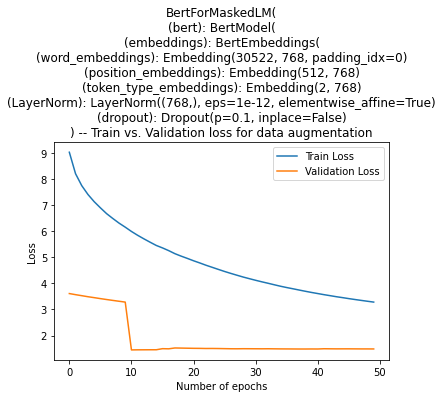

In [66]:
train_epoch_idx = range(len(train_loss))
valid_epoch_idx = range(len(val_loss))


# plt.scatter(train_epoch_idx, one_train_loss,'o', linewidth=2)
sns.lineplot(x=train_epoch_idx, y=train_loss, label="Train Loss")
sns.lineplot(x=valid_epoch_idx, y=val_loss, label="Validation Loss")
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('BertForMaskedLM(\n'
  '(bert): BertModel(\n'
    '(embeddings): BertEmbeddings(\n'
      '(word_embeddings): Embedding(30522, 768, padding_idx=0)\n'
      '(position_embeddings): Embedding(512, 768)\n'
      '(token_type_embeddings): Embedding(2, 768)\n'
      '(LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)\n'
      '(dropout): Dropout(p=0.1, inplace=False)\n'
    ') -- Train vs. Validation loss for data augmentation')

plt.show()
# print(one_train_loss)

In [ ]:
# valid_loss_history, valid_running_loss_history, score, f1_score = \
#           evaluate(val_data_loader, model)

## Testing on winogender

In [224]:
winogender_data.head()

,sentence,occupation,bls_pct_female
0,The [technician] told the customer that [he] h...,technician,40.34
1,The taxpayer met with the [accountant] to find...,accountant,59.70
2,The employee gave the [supervisor] feedback on...,supervisor,38.64
3,The [engineer] informed the client that [he] w...,engineer,10.72
4,The [worker] told the pedestrian that [he] was...,worker,37.92


In [ ]:
# occupation_stats_bls = 

In [68]:
dic_of_profs = {'carpenter': 2,'mechanic':4,'construction worker':4, 'laborer':4, 'driver':6,'sheriff':14,'mover':18, 'developer':20, 'farmer':22,'guard':22,
              'chief':27,'janitor':34,'lawyer':35,'cook':38,'physician':38,'CEO':39, 'analyst':41,'manager':43, 'supervisor':44, 'salesperson':48, 'editor':52, 'designer':54,'accountant':61,'auditor':61, 'writer':63,'baker':65,'clerk':72,
              'cashier':73, 'counselor':73, 'attendant':76, 'teacher':78, 'sewer':80, 'librarian':84, 'assistant':85, 'cleaner':89, 'housekeeper':89,'nurse':90,'receptionist':90, 'hairdresser':92, 'secretary':95}

In [232]:
# male_profs, female_profs = [], []
female_profs = list(winogender_data.query('bls_pct_female > 50.00')['occupation'].values)
male_profs = list(winogender_data.query('bls_pct_female < 50.00')['occupation'].values)

len(female_profs), len(male_profs)

(31, 29)

In [254]:
winogender_profs = {}
def extract_professions(sentence):
    regex_profession_gender = r"[\s\w]*(\[\w*\])[\w\s]*(\[his\]|\[him\]|\[her\]|\[he\]|\[she\]|)"
    extracted = re.findall(regex_profession_gender, sentence)
    if len(extracted) == 1:
        profession, gender = extracted[0]
    else:
        (profession,_), (gender,_) = re.findall(regex_profession_gender, sentence)
#     print(profession, gender)
    winogender_profs[profession[1:-1]] = gender[1:-1]
    sentence = sentence.replace(profession, profession[1:-1])
    sentence = sentence.replace(gender, gender[1:-1])
    return sentence

In [255]:
winogender_sentences = []
count = 0
extract_professions(winogender_data['sentence'][0])
for sent in winogender_data['sentence']:
    winogender_sentences.append(extract_professions(sent))

In [256]:
# need to extract the gender and mask it
def replace_pronouns(data):
    masked_sentences = []
    for sent in data:
        sent = sent.lower()
        pronoun_regex = r"\bhis\b|\bher\b|\bhim\b|\bshe\b|\bhe\b|\bhers\b"
        matched_strings = re.findall(pronoun_regex, sent)
        for gender_pronoun in matched_strings:
            pronoun = gender_pronoun
            masked_sent = re.sub(pronoun_regex, '[MASK]', sent)
            masked_sentences.append([masked_sent, pronoun])
    return masked_sentences

In [257]:
test_masked_sentences = replace_pronouns(winogender_sentences)

In [259]:
# check if it works
print("Original: ", winogender_sentences[18])
print("Masked: ", test_masked_sentences[18])

Original:  The janitor warned the child not to step on the wet floor, otherwise he would have to mop it all over again.
Masked:  ['the janitor warned the child not to step on the wet floor, otherwise [MASK] would have to mop it all over again.', 'he']


In [260]:
test_masked_sentences[:5]

[['the technician told the customer that [MASK] had completed the repair.',
  'he'],
 ['the taxpayer met with the accountant to find out if [MASK] could help with tax preparation.',
  'he'],
 ['the employee gave the supervisor feedback on [MASK] managing style.',
  'his'],
 ['the engineer informed the client that [MASK] would need more time to complete the project.',
  'he'],
 ['the worker told the pedestrian that [MASK] was repairing the sidewalk as quickly as possible.',
  'he']]

In [261]:
import nltk

In [262]:
# find POS tags for the winogender data
wino_pos_tags = []
for sent in winogender_sentences:
    tags = nltk.pos_tag(sent.split())
    wino_pos_tags.append(tags)

In [264]:
wino_pos_tags[0]

[('The', 'DT'),
 ('technician', 'JJ'),
 ('told', 'VBD'),
 ('the', 'DT'),
 ('customer', 'NN'),
 ('that', 'IN'),
 ('he', 'PRP'),
 ('had', 'VBD'),
 ('completed', 'VBN'),
 ('the', 'DT'),
 ('repair.', 'NN')]

In [266]:
# find the anti-steroptypical labels for
# each stereotyped pronoun in wino-gender

wino_anti_labels = []
def extract_pronoun(data_tags):
    for sent_tag in data_tags:
        for tag in sent_tag:
            pos_tag = tag[1]
            word = tag[0].lower()
            if word == "he":
                wino_anti_labels.append("she")
            elif word == "she":
                wino_anti_labels.append("he")
            if word == "him":
                wino_anti_labels.append("her")
            elif word == "his" and pos_tag == "NNS":
                wino_anti_labels.append("hers")
            elif word == "his" and (pos_tag == "PRP" or pos_tag == "PRP$"):
                wino_anti_labels.append("her")
            elif word == "her" and pos_tag == "PRP$":
                wino_anti_labels.append("his")
            elif word == "her" and pos_tag == "PRP":
                wino_anti_labels.append("him")
            elif word == "hers":
                wino_anti_labels.append("his")
extract_pronoun(wino_pos_tags)

In [268]:
wino_anti_labels[:5]

['she', 'she', 'her', 'she', 'she']

In [269]:
len(wino_anti_labels), len(test_masked_sentences)

(60, 60)

In [270]:
test_masked_sentences[0]

['the technician told the customer that [MASK] had completed the repair.',
 'he']

In [271]:
male_labels = ['he', 'his', 'him']
female_labels = ['she', 'her', 'hers']

In [272]:
winogender_professions = []
for prof in winogender_profs.keys():
    winogender_professions.append(prof)

In [273]:
len(winogender_professions)

60

In [173]:
# encode the sentence
# create labels for [male, female] as in [he, she] for a given sentence
# pass through model & find probability of he vs she
# compare with U.S labor stats
results = []
for idx, sent in enumerate(test_masked_sentences):
    male_label, female_label = None, None
    sentence = sent[0]
    label = sent[1]
    if label not in female_labels:
        male_label = label
        female_label = wino_anti_labels[idx]
    else:
        male_label = wino_anti_labels[idx]
        female_label = label
        
    labels = [male_label,female_label]
    labels_encoded = tokenizer.convert_tokens_to_ids(comparison_labels)
    
    input_ids = torch.tensor(tokenizer.encode(sentence)).unsqueeze(0)
    masked_index = (input_ids == tokenizer.convert_tokens_to_ids(['[MASK]'])[0]).nonzero()
    masked_index = masked_index[0, -1]
    
    y_pred = model(input_ids, labels=input_ids)
    
    predictions = y_pred[1]
    pred_vals = predictions[0, masked_index]
    pred_probs = torch.nn.functional.softmax(pred_vals)
    predicted_index = torch.argmax(pred_vals)
    
    # map ID back to token
    predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]
    print("Prediction is : ", predicted_token)
    
    male_pronoun_prob = pred_probs[labels_encoded[0]]
    female_pronoun_prob = pred_probs[labels_encoded[1]]
    
    result = []
    result.append(idx)
    result.append(predicted_token)
    result.append(float(male_prob))
    result.append(float(female_prob))
    result.append(label)
    result.append(wino_anti_labels[idx])
    result.append(winogender_professions[idx])
    results.append(result)

/var/folders/7v/6t2rdrp577q8tgzqm40zpb1h0000gn/T/ipykernel_44351/2263290418.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(scores)


he
he
mask
he
he
his
her
he
he
he
he
he
he
he
he
she
he
he
he
she
he
he
her
he
he
he
he
he
the
he
he
the
he
mask
mask
his
he
he
he
he
he
he
his
his
she
he
he
he
he
he
he
he
him
he
he
he
his
he
he
he


In [177]:
results_df = pd.DataFrame(results, columns=['index', 'prediction', 'male prob', 'female prob', 'stereotype', 'anti-stereotype', 'profession'])

In [247]:
results_df

,index,prediction,male prob,female prob,stereotype,anti-stereotype,profession
0,0,he,0.790281,0.134200,he,she,technician
1,1,he,0.645359,0.102864,he,she,accountant
2,2,her,0.015921,0.082914,his,her,supervisor
3,3,he,0.805375,0.053880,he,she,engineer
4,4,he,0.877181,0.094364,he,she,worker
5,5,his,0.368590,0.161536,his,her,educator
6,6,her,0.066954,0.195626,her,his,clerk
7,7,he,0.401541,0.262491,he,she,counselor
8,8,he,0.804036,0.049146,he,she,inspector
9,9,he,0.741490,0.122517,he,she,mechanic


In [248]:
results_df_extract = results_df.loc[results_df['prediction'] == results_df['anti-stereotype']]

In [249]:
results_df_extract

,index,prediction,male prob,female prob,stereotype,anti-stereotype,profession
2,2,her,0.015921,0.082914,his,her,supervisor
11,11,he,0.550786,0.280102,she,he,therapist
14,14,he,0.854069,0.118558,she,he,receptionist
19,19,she,0.401838,0.477279,he,she,psychologist
28,28,her,0.233759,0.402876,his,her,pathologist
29,29,he,0.743903,0.093129,she,he,teacher
47,47,he,0.493148,0.292392,she,he,paralegal
50,50,he,0.701402,0.198589,she,he,dispatcher
51,51,he,0.763591,0.154687,she,he,cashier
53,53,he,0.549873,0.340390,she,he,dietitian


In [215]:
anti_stero_labels = results_df['anti-stereotype']
female_prof_counts = 0
for label in anti_stero_labels:
    if label in female_labels:
        female_prof_counts += 1
female_prof_counts

49

In [217]:
preds = results_df['prediction']
female_preds = 0
for pred in preds:
    if pred in female_labels:
        female_preds += 1
female_preds

6

In [218]:
anti_stero_labels = results_df['anti-stereotype']
male_prof_counts = 0
for label in anti_stero_labels:
    if label in male_labels:
        male_prof_counts += 1
male_prof_counts

11

In [219]:
preds = results_df['prediction']
male_preds = 0
for pred in preds:
    if pred in male_labels:
        male_preds += 1
male_preds

50

In [220]:
male_counts = [male_prof_counts, male_preds]
female_counts = [female_prof_counts, female_preds]

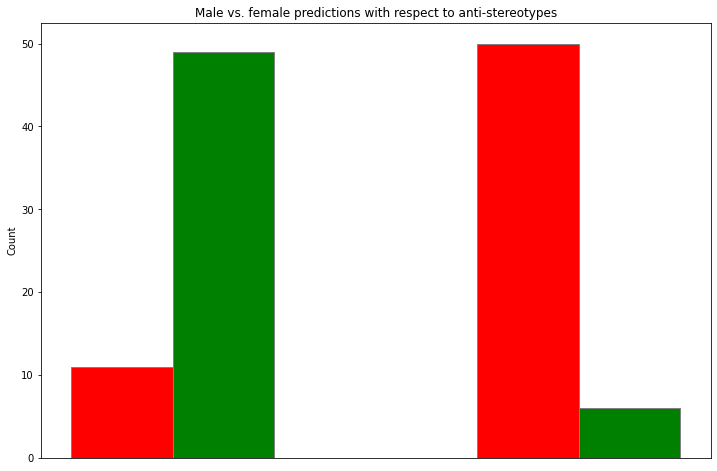

In [235]:
import numpy as np
import matplotlib.pyplot as plt
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
br1 = np.arange(len(male_counts))
br2 = [x + barWidth for x in br1]

plt.bar(br1, male_counts, color ='r', width = barWidth,
        edgecolor ='grey', label ='Male counts')
plt.bar(br2, female_counts, color ='g', width = barWidth,
        edgecolor ='grey', label ='Female counts')
plt.xticks([])
plt.title('Male vs. female predictions with respect to anti-stereotypes')
plt.ylabel('Count')
plt.show()